In [1178]:
import matplotlib.pyplot as plt, numpy as np, os, pathlib
from datetime import datetime


In [1179]:
#constants:
HOME = 'G28'        #this is a custom saved location
positioning = 'G90' #absolute positioning
units = 'G21'       #everything using mm

#settings:
feed_rate = float(1)
material = 'PCL'
printer = 'Aero'

#platform limits(be aware that it could go over if inaccurate)
x_max = 120     #mm
y_max = 120     #mm

#Line Settings: How wide and tall for the box of lines: in mm
product_width = 80  #mm
product_height = 40 #mm
num_groups = 5     #number of line groups - consecutive lines made with same speed
line_per_group = 10  #mm gap between lines of the same line group
ratio_of_dxgroup_dxline = 2 #ratio between distance between lines and distance between groups of lines so dxg/dxl
dx_line = product_width/(num_groups*(line_per_group-1)+ratio_of_dxgroup_dxline*(num_groups-1))
print(dx_line)
dx_group = dx_line*ratio_of_dxgroup_dxline
print(dx_group)

#for incrementing pts only:
pts_per_line = 10    #mm

#testing all speeds within range:
nozzle_v_min = 10       #mm/s
nozzle_v_max = 100      #mm/s
nozzle_dv = (nozzle_v_max-nozzle_v_min)/num_groups   #mm/s

#UNUSED EXPERIMENTAL STUFF:
#if u do pressure instead:
ejection_p_min = 1      #
ejection_p_max = 5      #
ejection_dp = (ejection_p_max-ejection_p_min)/num_groups #

#attempt to calculate critical translation speed:
initital_fiber_dia = 1.0  #mm
final_fiber_dia = initital_fiber_dia*pow(nozzle_v_min/nozzle_dv, 0.5)
#final_fiber_dia = initital_fiber_dia*pow(ejection_p_min/ejection_dp, 0.5)

1.509433962264151
3.018867924528302


In [1180]:
#calculate 

In [1181]:
#Coordinate plotting:
input_coordinate = []

#Get beginning location: gotta find it

#use for nxn product
def get_coordinate_init_centered():
    #always want the product to be centered, cannot go beyond the limit
    coord_init = np.array([x_max-product_width,y_max-product_height])/2
    return coord_init
    
#use for all else
def get_coordinate_init_cornered():
    #will just be lower left corner
    return [10,10]

if(product_width == product_height):coord_init = get_coordinate_init_centered()
else: coord_init = get_coordinate_init_cornered()

#generate rough lines, then can populate new coordinate list with linspaced points for increments

def find_next_pt(input, viable_opt):
    if(input == viable_opt[0]):
        return viable_opt[1]
    return viable_opt[0]

#generating lines w/out increment:
input_coordinate.append(coord_init)
for group in range(num_groups):
    options = [coord_init[1], coord_init[1]+product_height]
    for line in range(line_per_group):
        
        current_x = (input_coordinate[-1])[0]
        current_y = (input_coordinate[-1])[1]
        next_pt = [current_x,find_next_pt(current_y,options)]
        input_coordinate.append(next_pt)
        
        if line != line_per_group-1:
            current_x = (input_coordinate[-1])[0]
            current_y = (input_coordinate[-1])[1]
            next_pt = [current_x+dx_line, current_y]
            input_coordinate.append(next_pt)
        
    current_x = (input_coordinate[-1])[0]
    current_y = (input_coordinate[-1])[1]
    if group != num_groups-1:
        input_coordinate.append([current_x+dx_group,current_y])

input_coordinate = np.array(input_coordinate)
print(input_coordinate)
print(len(input_coordinate))

[[10.         10.        ]
 [10.         50.        ]
 [11.50943396 50.        ]
 [11.50943396 10.        ]
 [13.01886792 10.        ]
 [13.01886792 50.        ]
 [14.52830189 50.        ]
 [14.52830189 10.        ]
 [16.03773585 10.        ]
 [16.03773585 50.        ]
 [17.54716981 50.        ]
 [17.54716981 10.        ]
 [19.05660377 10.        ]
 [19.05660377 50.        ]
 [20.56603774 50.        ]
 [20.56603774 10.        ]
 [22.0754717  10.        ]
 [22.0754717  50.        ]
 [23.58490566 50.        ]
 [23.58490566 10.        ]
 [26.60377358 10.        ]
 [26.60377358 50.        ]
 [28.11320755 50.        ]
 [28.11320755 10.        ]
 [29.62264151 10.        ]
 [29.62264151 50.        ]
 [31.13207547 50.        ]
 [31.13207547 10.        ]
 [32.64150943 10.        ]
 [32.64150943 50.        ]
 [34.1509434  50.        ]
 [34.1509434  10.        ]
 [35.66037736 10.        ]
 [35.66037736 50.        ]
 [37.16981132 50.        ]
 [37.16981132 10.        ]
 [38.67924528 10.        ]
 

Text(0.5, 1.0, 'vector form')

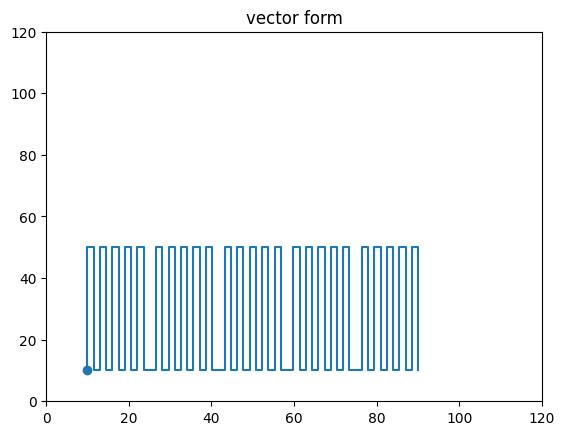

In [1182]:
#graph points
plt.scatter(input_coordinate[0][0],input_coordinate[0][1])
x = input_coordinate[:,0]
y = input_coordinate[:,1]
plt.xlim(0,120)
plt.ylim(0,120)
plt.plot(x,y)
plt.title("vector form")

In [1183]:
spliced_coordinate = np.array([coord_init])

#incrementize coordinates:
def splice_vector_into_pts(xy_init, xy_final, pts_per_line):
    result = np.linspace(xy_init,xy_final,pts_per_line)
    return result

for set in range(len(input_coordinate)-1):
    spliced_vector = splice_vector_into_pts(input_coordinate[set],input_coordinate[set+1],pts_per_line)
    spliced_coordinate = np.concatenate((spliced_coordinate,spliced_vector),axis=0)

spliced_coordinate = np.delete(spliced_coordinate,0,0)

#print(spliced_coordinate)
print(len(spliced_coordinate))

990


Text(0.5, 1.0, 'spliced')

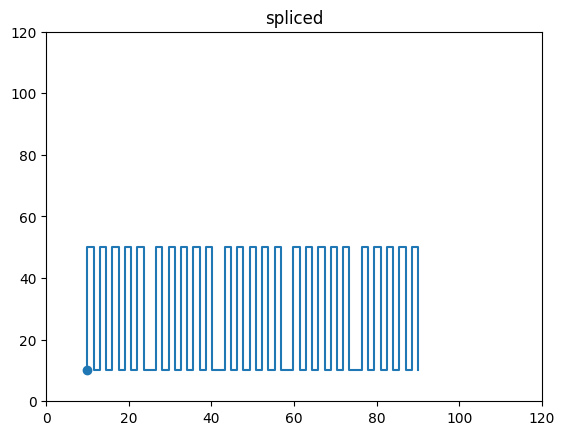

In [1184]:
#graph points of splice (should look the same as previous graph)
plt.scatter(spliced_coordinate[0][0],spliced_coordinate[0][1])
x = spliced_coordinate[:,0]
y = spliced_coordinate[:,1]
plt.xlim(0,120)
plt.ylim(0,120)
plt.plot(x,y)
plt.title("spliced")

In [1185]:
#create array for each point's speed
speed_corresponding_to_spliced_coord = np.linspace(nozzle_v_min,nozzle_v_max,len(spliced_coordinate))*60 #turns it into mm/s otherwise is mm/min
#print(speed_corresponding_to_spliced_coord)
print(len(speed_corresponding_to_spliced_coord))

990


In [1186]:
#gcode writer that will combine coordinate information and speed information
def get_gcode_block(position, speed):
    return "G1 X{position[0]} Y{position[1]} F{speed}".format(position, speed)

def get_gcode_block_movement_only(position):
     return "G1 X" + str(position[0])+ " Y" + str(position[1])

In [1187]:
if(input("Create File? (y/n)") == "y"):
    
    write_nozzle_code = False
    if(input("Write Nozzel Code? (y/n)") == "y"): write_nozzle_code = True
    
    #create file:
    file_name = input("Enter file name: ")
    #path = pathlib.Path().resolve()

    with open(str(file_name) + ".gcode", "w") as f:
        #description
        f.write(";File Name: " + str(file_name))
        f.write("\n;Time Generated: " + str(datetime.today().strftime('%Y-%m-%d %H:%M:%S')))  #get date
        f.write("\n;Printer Type: " + str(printer))
        #set up
        f.write("\n\n\n" + str(positioning))
        f.write("\n" + str(units))
        f.write("\n" + str(HOME) + "\n")
        
        if(write_nozzle_code == 0): f.write("\n;selected movement only")
        for i in range(len(spliced_coordinate)):
            if(write_nozzle_code):
                #include preheat code here
                f.write("\nM190 S60\nM104 S200\nM109 S200\nM82\n\n")
                line = get_gcode_block(spliced_coordinate[i], speed_corresponding_to_spliced_coord[i])
            else:
                line = get_gcode_block_movement_only(spliced_coordinate[i])
            f.write("\n" + line)
        
        #ending code here
        f.write("\n\n\nM104 T0 S0\nM140 S0\nM84\nM30")
        f.write("\n;end of code")
    